# Plain neural network training
As in https://github.com/carrascomj/gcn-prot/, train a plain neural network with the data.

In [1]:
import nnbody
import torch

import torch.nn.functional as F
from os.path import join, pardir
from sklearn.metrics import confusion_matrix

In [2]:
ROOT_DIR = pardir

## Initialize Data

In [3]:
largest = nnbody.features.get_longest(join(ROOT_DIR, "data", "features", "bioil", "graph"))
print(f"Largest protein has {largest} aminoacids")

Largest protein has 114 aminoacids


In [4]:
data_path = join(ROOT_DIR, "data", "features", "bioil")

In [5]:
train, valid, test = nnbody.features.get_datasets(
    data_path=data_path,
    nb_nodes=largest,
    task_type="regression",
    nb_classes=1,
    split=[0.9, 0.05, 0.05],
    seed=42,
    augment=1, # data augmentation factor x3
)

CLASS[COUNTS]:  68.65087870064526 1
CLASS[COUNTS]:  69.92547225952151 1
CLASS[COUNTS]:  69.99939219156903 1
CLASS[COUNTS]:  70.2204913912754 1
CLASS[COUNTS]:  70.73215993245442 1
CLASS[COUNTS]:  72.33274841308597 1
CLASS[COUNTS]:  72.54738936623046 1
CLASS[COUNTS]:  72.6474881067593 1
CLASS[COUNTS]:  73.05039469401044 1
CLASS[COUNTS]:  73.5173823038737 1
CLASS[COUNTS]:  73.62487594460994 1
CLASS[COUNTS]:  73.66552734375 1
CLASS[COUNTS]:  73.66566467285156 1
CLASS[COUNTS]:  73.681494538168 1
CLASS[COUNTS]:  73.75874304046977 1
CLASS[COUNTS]:  73.75915018717447 1
CLASS[COUNTS]:  73.9057159423828 1
CLASS[COUNTS]:  73.9458669026693 1
CLASS[COUNTS]:  73.95344306975522 1
CLASS[COUNTS]:  73.97044556010495 1
CLASS[COUNTS]:  74.0791015625 1
CLASS[COUNTS]:  74.11929829915364 1
CLASS[COUNTS]:  74.47934977213544 1
CLASS[COUNTS]:  74.52510517966677 1
CLASS[COUNTS]:  74.70020981393013 1
CLASS[COUNTS]:  74.82549667358401 1
CLASS[COUNTS]:  74.96727498372397 1
CLASS[COUNTS]:  75.00211628195487 1
CLASS[

Since we have a small dataset, we can store everything in memory. 

In [6]:
train.flush()
test.flush()
valid.flush()

In [7]:
print(f"Train: {len(train)}\nTest: {len(test)}\nValidation: {len(valid)}")

Train: 50
Test: 3
Validation: 3


## FFNN

Each instance in the dataset retrieves a list of four matrices:

* feature matrix: 29 x 185. This corresponds to the aminoacid type (one-hot encoded vector of length 23), residue depth, residue orientation and 4 features encoding the positional index with a sinusoidal transformation.
* coordinates: 3 x 185. x,y,z coordinates of every aminoacid in the crystal (centered) (not used for FFNN)
* mask: to be applied to the adjacency to discard ill-identified aminoacids.
* y: 2 labels, Kras/Hras.


Instatiate the NN model, the optimizer and the criterion.

In [8]:
model = nnbody.models.FFNN(
    feats=29,             # features in feature matrix
    hidden=[20, 50, 20],      # number of neurons in convolutional layers (2 in this case)
    #hidden_norm=25,
    label=1,              # regression (features on y = 1)
    nb_nodes=largest,     # for last layer
    dropout=0,
    #D=1,
    cuda=False,           # required for sparsize and fit_network
    out_act=lambda x: nnbody.models.utils.range_activation(x, 68, 80)
)

In [9]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.MSELoss()

## FFNN Training loop¶

Epoch 5 (0/1)            

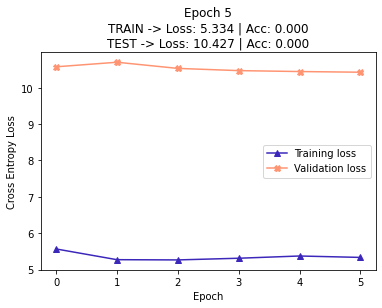

Epoch 10 (0/1)            

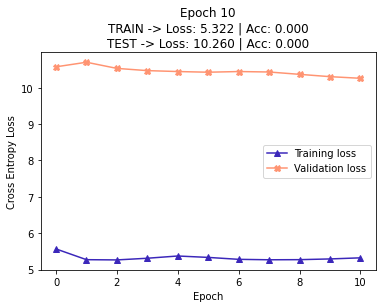

Epoch 15 (0/1)            

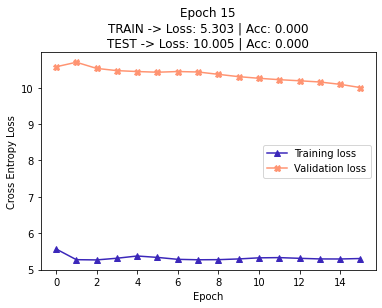

Epoch 20 (0/1)            

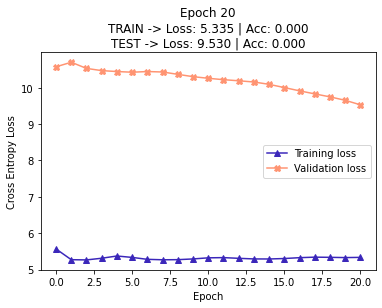

Epoch 25 (0/1)            

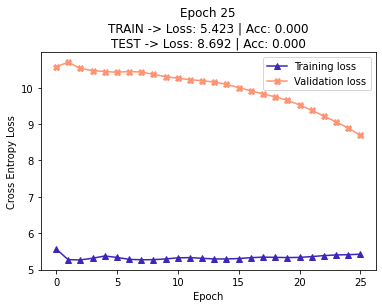

Epoch 30 (0/1)            

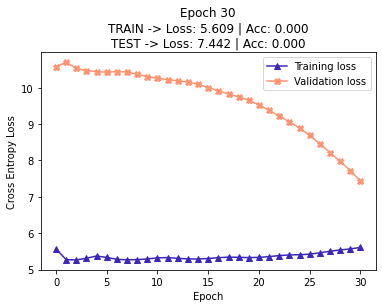

Epoch 35 (0/1)            

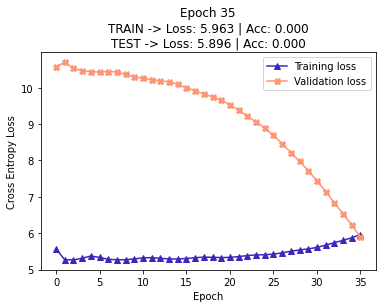

Epoch 40 (0/1)            

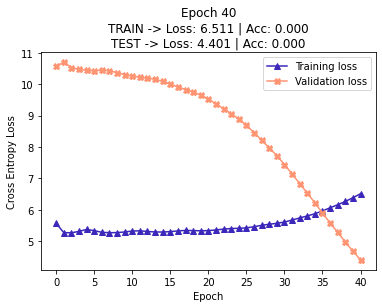

Epoch 45 (0/1)            

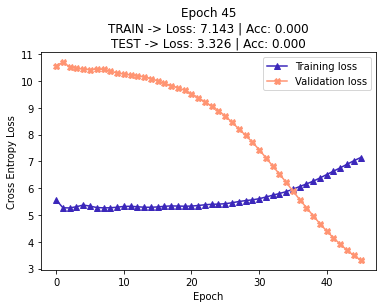

Epoch 50 (0/1)            

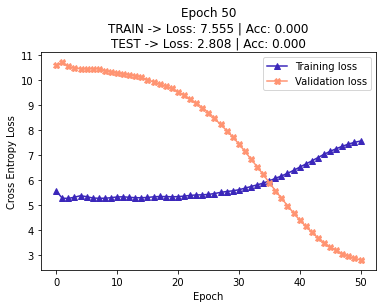

In [10]:
save_path = join(ROOT_DIR, "models", "01_FFNN_weigths.pt")
model = nnbody.models.fit_network(
    model, train, test, optimizer, criterion,
    batch_size=56,   # 6 batches per epoch
    epochs=51,
    debug=True,      # will print progress of epochs
    plot_every=5,    # loss plot/epoch
    save=save_path   # best weights (test set) will be saved here
)

In [11]:
model.load_state_dict(torch.load(join(ROOT_DIR, "models", "01_FFNN_weigths.pt")))

<All keys matched successfully>

## FFNN Validation


In [12]:
prediction, truth = [], []
model.eval()
for batch in torch.utils.data.DataLoader(
    valid, shuffle=False, batch_size=1, drop_last=False
):
    pred, y = nnbody.models.forward_step(batch, model, False)
    prediction.append(pred[0].cpu().tolist())
    truth.append(y[0].cpu().tolist())

In [13]:
prediction

[[74.5502700805664], [72.65205383300781], [74.55113220214844]]

In [14]:
truth

[[73.75914764404297], [79.53392028808594], [75.65596771240234]]